# Импортируем необходимые библиотеки

In [136]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings('ignore')

# Загрузим данные

In [137]:
ROOT_DIR = 'mlcourse-dota2-win-prediction'

train_features = pd.read_csv(os.path.join(ROOT_DIR, 'train_features.csv'), index_col='match_id_hash')
train_targets = pd.read_csv(os.path.join(ROOT_DIR, 'train_targets.csv'), index_col='match_id_hash')

In [138]:
train_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0


In [139]:
train_targets.head(2)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN


In [140]:
X = train_features
y = train_targets['radiant_win']

# EDA (5 баллов)

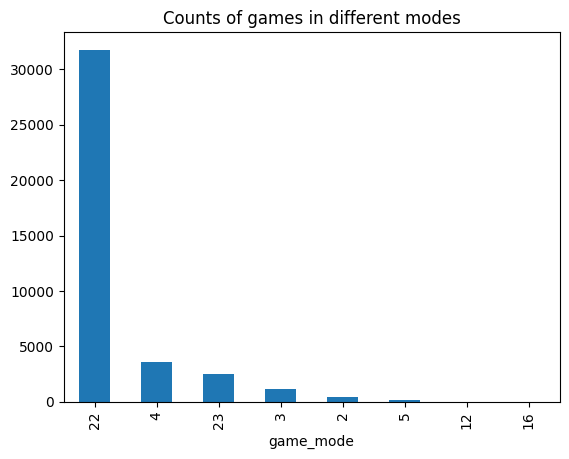

In [141]:
# тут EDA, который вы считаете необходимым, например, изучим количество игр в разных режимах

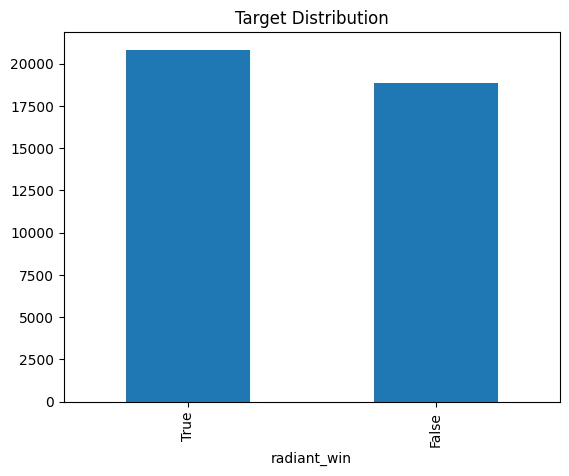

In [142]:
# посмотрим распределение таргета

In [143]:
... # далее ваш EDA - все, что вы считаете необходимым

Ellipsis

# Обучим CatBoost на чистых данных и посмотрим на метрики

In [144]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8187, Accuracy score: 0.7287
FOLD 1, Validation ROC-AUC score: 0.8029, Accuracy score: 0.7117
FOLD 2, Validation ROC-AUC score: 0.8007, Accuracy score: 0.7157
FOLD 3, Validation ROC-AUC score: 0.8047, Accuracy score: 0.7176
FOLD 4, Validation ROC-AUC score: 0.8060, Accuracy score: 0.7146

Overall CAT OOF ROC-AUC: 0.8066, OOF Accuracy: 0.7176


# Генерация фичей (5 баллов)

Генерация фичей является одной из важнейших частей построения пайплайна машинного обучения. В данной части вам предлагается придумать и сгенерировать полезные фичи для модели. Важно: они должны повысить метрику. В качестве примера сгенерированы статистические фичи. Вы можете не использовать их, если не считаете их нужными.

In [145]:
def fe(data):
    for c in [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 
        'health', 'max_health', 'max_mana', 'level', 'x', 'y', 
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'firstblood_claimed', 'teamfight_participation', 'towers_killed', 
        'roshans_killed', 'obs_placed', 'sen_placed'
    ]:
        r_columns = [f'r{i}_{c}' for i in range(1, 6)]
        d_columns = [f'd{i}_{c}' for i in range(1, 6)]

        eps = 1e-8 # избегаем деления на 0
        
        data['r_total_' + c] = data[r_columns].sum(1)
        data['d_total_' + c] = data[d_columns].sum(1)
        data['total_' + c + '_ratio'] = data['r_total_' + c] / (data['d_total_' + c] + eps)
        
        # попробуйте другие статистики, например среднее или стандартное отклонение
        # более того, если считаете, что фичи, основанные на статистиках не нужны, можете их не использовать - они приведены в качестве примера
    ...

    return data

# Теперь обучим CatBoost на данных с новыми фичами и посмотрим на метрики

In [146]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8368, Accuracy score: 0.7456
FOLD 1, Validation ROC-AUC score: 0.8174, Accuracy score: 0.7285
FOLD 2, Validation ROC-AUC score: 0.8210, Accuracy score: 0.7325
FOLD 3, Validation ROC-AUC score: 0.8222, Accuracy score: 0.7341
FOLD 4, Validation ROC-AUC score: 0.8259, Accuracy score: 0.7370

Overall OOF ROC-AUC: 0.8246, OOF Accuracy: 0.7355


# Обработка категориальных фичей средствами CatBoost

Попробуем подать категориальные фичи в модель через cat_features.

In [147]:
# выделим очевидные категориальные фичи - вы можете попробовать выделить больше / сгенерировать новые или же вовсе отказаться от этой идеи
cats = ['game_mode', 'lobby_type']

In [148]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8392, Accuracy score: 0.7485
FOLD 1, Validation ROC-AUC score: 0.8187, Accuracy score: 0.7265
FOLD 2, Validation ROC-AUC score: 0.8210, Accuracy score: 0.7298
FOLD 3, Validation ROC-AUC score: 0.8217, Accuracy score: 0.7327
FOLD 4, Validation ROC-AUC score: 0.8267, Accuracy score: 0.7374

Overall CAT w/ FE OOF ROC-AUC: 0.8254, OOF Accuracy: 0.7350


# Отбор фичей (5 баллов)

Возможно, на этапе генерации фичей вы решили прибегнуть к автоматической генерации (если нет, то советую обратить внимание на библиотеку OpenFE), или же просто генерировали все подряд. Также, возможно, исходные данные содержали бесполезные и шумные фичи.

Вам предлагается исследовать это и оставить только те фичи, которые вы считаете важными.

Идеи для отбора фичей: 
- по feature importance
- по permutation importance
- по shap values
- recursive feature elimination
- sequential feature selection

Также обратите внимание на гайд от catboost: https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb

In [149]:
# бейзлайн: используем встроенные инструменты catboost - вы можете работать с ним или обратиться к другим инструментам
# здесь нужно быть аккуратным, ведь удаление фичей всегда может привести к падению скора 
# необходимо подобрать грамотный подход, а это можно сделать только путем экспериментов

model = CatBoostClassifier(
    cat_features=cats,
    random_state=69,
    verbose=0,
    thread_count=4
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

X_train = fe(X_train)
X_test = fe(X_test)

train_pool = Pool(X_train, y_train, cat_features=cats)
test_pool = Pool(X_test, y_test, cat_features=cats)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(X_train.shape[1])),
    num_features_to_select=300, # количество фичей, которое хотим отобрать - один из самых важных параметров
    algorithm=None, # точно стоит поиграться с выбором алгоритма - важный параметр !!!
    steps=None, # количество шагов
    shap_calc_type=None,
    train_final_model=False,
    verbose=None,
    logging_level=None,
    plot=False
)

selected_features = summary['selected_features'] # отобранные фичи

Learning rate set to 0.073263
Step #1 out of 1

bestTest = 0.4993145893
bestIteration = 367

Shrink model to first 368 iterations.
Feature #247 eliminated
Feature #111 eliminated
Feature #354 eliminated
Feature #18 eliminated
Feature #394 eliminated
Feature #298 eliminated
Feature #137 eliminated
Feature #13 eliminated
Feature #205 eliminated
Feature #234 eliminated
Feature #29 eliminated
Feature #277 eliminated
Feature #130 eliminated
Feature #11 eliminated
Feature #155 eliminated
Feature #226 eliminated
Feature #253 eliminated
Feature #361 eliminated
Feature #201 eliminated
Feature #206 eliminated
Feature #202 eliminated
Feature #42 eliminated
Feature #433 eliminated
Feature #89 eliminated
Feature #212 eliminated
Feature #334 eliminated
Feature #312 eliminated
Feature #263 eliminated
Feature #199 eliminated
Feature #449 eliminated
Feature #93 eliminated
Feature #291 eliminated
Feature #349 eliminated
Feature #41 eliminated
Feature #90 eliminated
Feature #159 eliminated
Feature #348 e

# Обучим модель на отобранных и фичах и посмотрим на метрики

In [150]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8395, Accuracy score: 0.7480
FOLD 1, Validation ROC-AUC score: 0.8198, Accuracy score: 0.7312
FOLD 2, Validation ROC-AUC score: 0.8239, Accuracy score: 0.7347
FOLD 3, Validation ROC-AUC score: 0.8230, Accuracy score: 0.7360
FOLD 4, Validation ROC-AUC score: 0.8263, Accuracy score: 0.7372

Overall CAT w/ FE&FS OOF ROC-AUC: 0.8264, OOF Accuracy: 0.7374


# Блендинг: добавим XGBoost и LightGBM

In [151]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        metric='auc',
        early_stopping_round=100,
        verbosity=-1
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8397, Accuracy score: 0.7472
FOLD 1, Validation ROC-AUC score: 0.8204, Accuracy score: 0.7332
FOLD 2, Validation ROC-AUC score: 0.8215, Accuracy score: 0.7302
FOLD 3, Validation ROC-AUC score: 0.8216, Accuracy score: 0.7330
FOLD 4, Validation ROC-AUC score: 0.8263, Accuracy score: 0.7384

Overall LGB w/ FE&FS OOF ROC-AUC: 0.8258, OOF Accuracy: 0.7364


In [152]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]
    
    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        eval_metric='auc',
        early_stopping_rounds=100,
        use_label_encoder=False,
        enable_categorical=True, 
        tree_method='hist'
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8373, Accuracy score: 0.7481
FOLD 1, Validation ROC-AUC score: 0.8197, Accuracy score: 0.7312
FOLD 2, Validation ROC-AUC score: 0.8220, Accuracy score: 0.7313
FOLD 3, Validation ROC-AUC score: 0.8215, Accuracy score: 0.7308
FOLD 4, Validation ROC-AUC score: 0.8264, Accuracy score: 0.7391

Overall XGB w/ FE&FS OOF ROC-AUC: 0.8252, OOF Accuracy: 0.7361


In [153]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


Overall BLEND w/ FE&FS OOF ROC-AUC: 0.8274, OOF Accuracy: 0.7378


# Подбор гиперпараметров (15 баллов)

Для изучения того, какие гиперпараметры доступны у модели для выбора можно использовать '? ModelName'
Определитесь с тем, какие гиперпараметры вы хотите оптимизировать и укажите их в objective. Выполните поиск гиперпараметров с Optuna

In [112]:
# ? CatBoostClassifier

In [117]:
# ? lgb.LGBMClassifier

In [114]:
# ? XGBClassifier

In [154]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'random_state': 69,
        'verbose': 0,
        # добавьте сюда прочие гиперпараметры, к примеру l2_leaf_reg, random_strength, bagging_temperature, ...
    }
    
    if 'cats' in globals():
        params['cat_features'] = cats
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_cat = np.zeros(len(X))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=100,
            verbose=0
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_cat[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_cat)
    
    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

cat_params = study.best_params
cat_params

In [155]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_rounds': 100
        # добавьте сюда прочие гиперпараметры, к примеру num_leaves, min_child_samples, subsample, ...
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_lgb = np.zeros(len(X))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]
        
        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            categorical_feature=cats,
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_lgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_lgb)
    
    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

lgb_params = study.best_params
lgb_params

In [156]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
        # добавьте сюда прочие гиперпараметры, к примеру gamma, min_child_weight, subsample, ...
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_xgb = np.zeros(len(X))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]
        
        for col in cats:
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')
        
        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_xgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_xgb)
    
    return oof_roc_auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

xgb_params = study.best_params

# Обучим модели с новыми гиперпараметрами

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        **cat_params,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall Tuned CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # lgbm требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    final_params = {
        **best_params,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_round': 100
    }

    model = lgb.LGBMClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=cats
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall Tuned LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    # xgb требует указания категориальных фичей как 'category'
    for col in cats:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

    cat_columns = [X_train.columns.get_loc(col) for col in cats]

    final_params = {
        **xgb_params,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
    }

    model = XGBClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]
    
    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall Tuned XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

In [ ]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall Tuned BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

# Итоговая важность фичей

In [ ]:
# изучите итоговые важности фичей моделей catboost, lgbm, xgb (используйте обычный feature importance)
# можно использовать модели с последнего фолда
# если хочется более точно - можно посчитать важности на каждом фолде и усреднить (это опционально)

# ваш код:
...